In [2]:
!pip install tensorflow

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as  plt
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.utils import Sequence
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, TimeDistributed, LSTM
from tensorflow.keras.models import Model, Sequential

In [4]:
import os
import zipfile

# Create a hidden kaggle folder
os.makedirs('/root/.kaggle', exist_ok=True)

# Move kaggle.json to the kaggle folder
!mv kaggle.json /root/.kaggle/kaggle.json

# Set permissions
!chmod 600 /root/.kaggle/kaggle.json


In [5]:
!kaggle datasets download -d ismailnasri20/driver-drowsiness-dataset-ddd
!unzip -q driver-drowsiness-dataset-ddd.zip -d /content/driver_drowsiness_data


Dataset URL: https://www.kaggle.com/datasets/ismailnasri20/driver-drowsiness-dataset-ddd
License(s): unknown


In [6]:
!pip install split-folders


In [7]:
import splitfolders

data_dir = '/content/driver_drowsiness_data/Driver Drowsiness Dataset (DDD)'
output_dir = '/content/splitted_data'

# Split into 80% train, 15% val, 5% test
splitfolders.ratio(data_dir, output=output_dir, seed=1337, ratio=(.8, 0.15, 0.05))


Copying files: 41793 files [00:39, 1056.89 files/s]


In [8]:
train_dir = "/content/splitted_data/train"
test_dir = "/content/splitted_data/test"
val_dir = "/content/splitted_data/val"


In [9]:
train_data = ImageDataGenerator(rescale=1./255)
test_data = ImageDataGenerator(rescale=1./255)
val_data = ImageDataGenerator(rescale=1./255)

In [10]:
train_batches = train_data.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary',
    shuffle=True
)

Found 33434 images belonging to 2 classes.


In [11]:
val_batches = val_data.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary',
    shuffle=True
)

test_batches = test_data.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary',
    shuffle=False
)


Found 6268 images belonging to 2 classes.
Found 2091 images belonging to 2 classes.


Pixels of the first image after Normalization: 

[[[0.882353   0.8117648  0.7019608 ]
  [0.8862746  0.8196079  0.7019608 ]
  [0.882353   0.81568635 0.69803923]
  ...
  [0.9686275  0.93725497 0.8235295 ]
  [0.96470594 0.9333334  0.8196079 ]
  [0.96470594 0.9333334  0.8196079 ]]

 [[0.882353   0.8117648  0.7019608 ]
  [0.8862746  0.8196079  0.7019608 ]
  [0.8862746  0.8196079  0.7019608 ]
  ...
  [0.9686275  0.93725497 0.8235295 ]
  [0.9686275  0.93725497 0.8235295 ]
  [0.96470594 0.9333334  0.8196079 ]]

 [[0.882353   0.8117648  0.7019608 ]
  [0.8862746  0.8196079  0.7019608 ]
  [0.8862746  0.8196079  0.7019608 ]
  ...
  [0.97647065 0.94117653 0.82745105]
  [0.9686275  0.93725497 0.8235295 ]
  [0.9686275  0.93725497 0.8235295 ]]

 ...

 [[0.48627454 0.42352945 0.34509805]
  [0.48627454 0.42352945 0.34509805]
  [0.48627454 0.42352945 0.34509805]
  ...
  [0.49803925 0.4784314  0.41176474]
  [0.49411768 0.47058827 0.40784317]
  [0.49803925 0.4784314  0.41176474]]

 [[0.48627454 0.42352945 

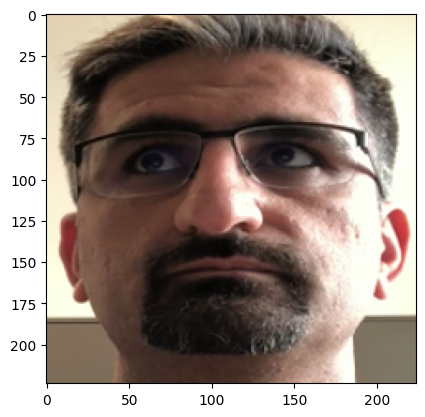

In [12]:
images, labels = next(train_batches)
print(f"Pixels of the first image after Normalization: \n\n{images[0]}") #print pixels of the first img
plt.imshow(images[0])
plt.show()

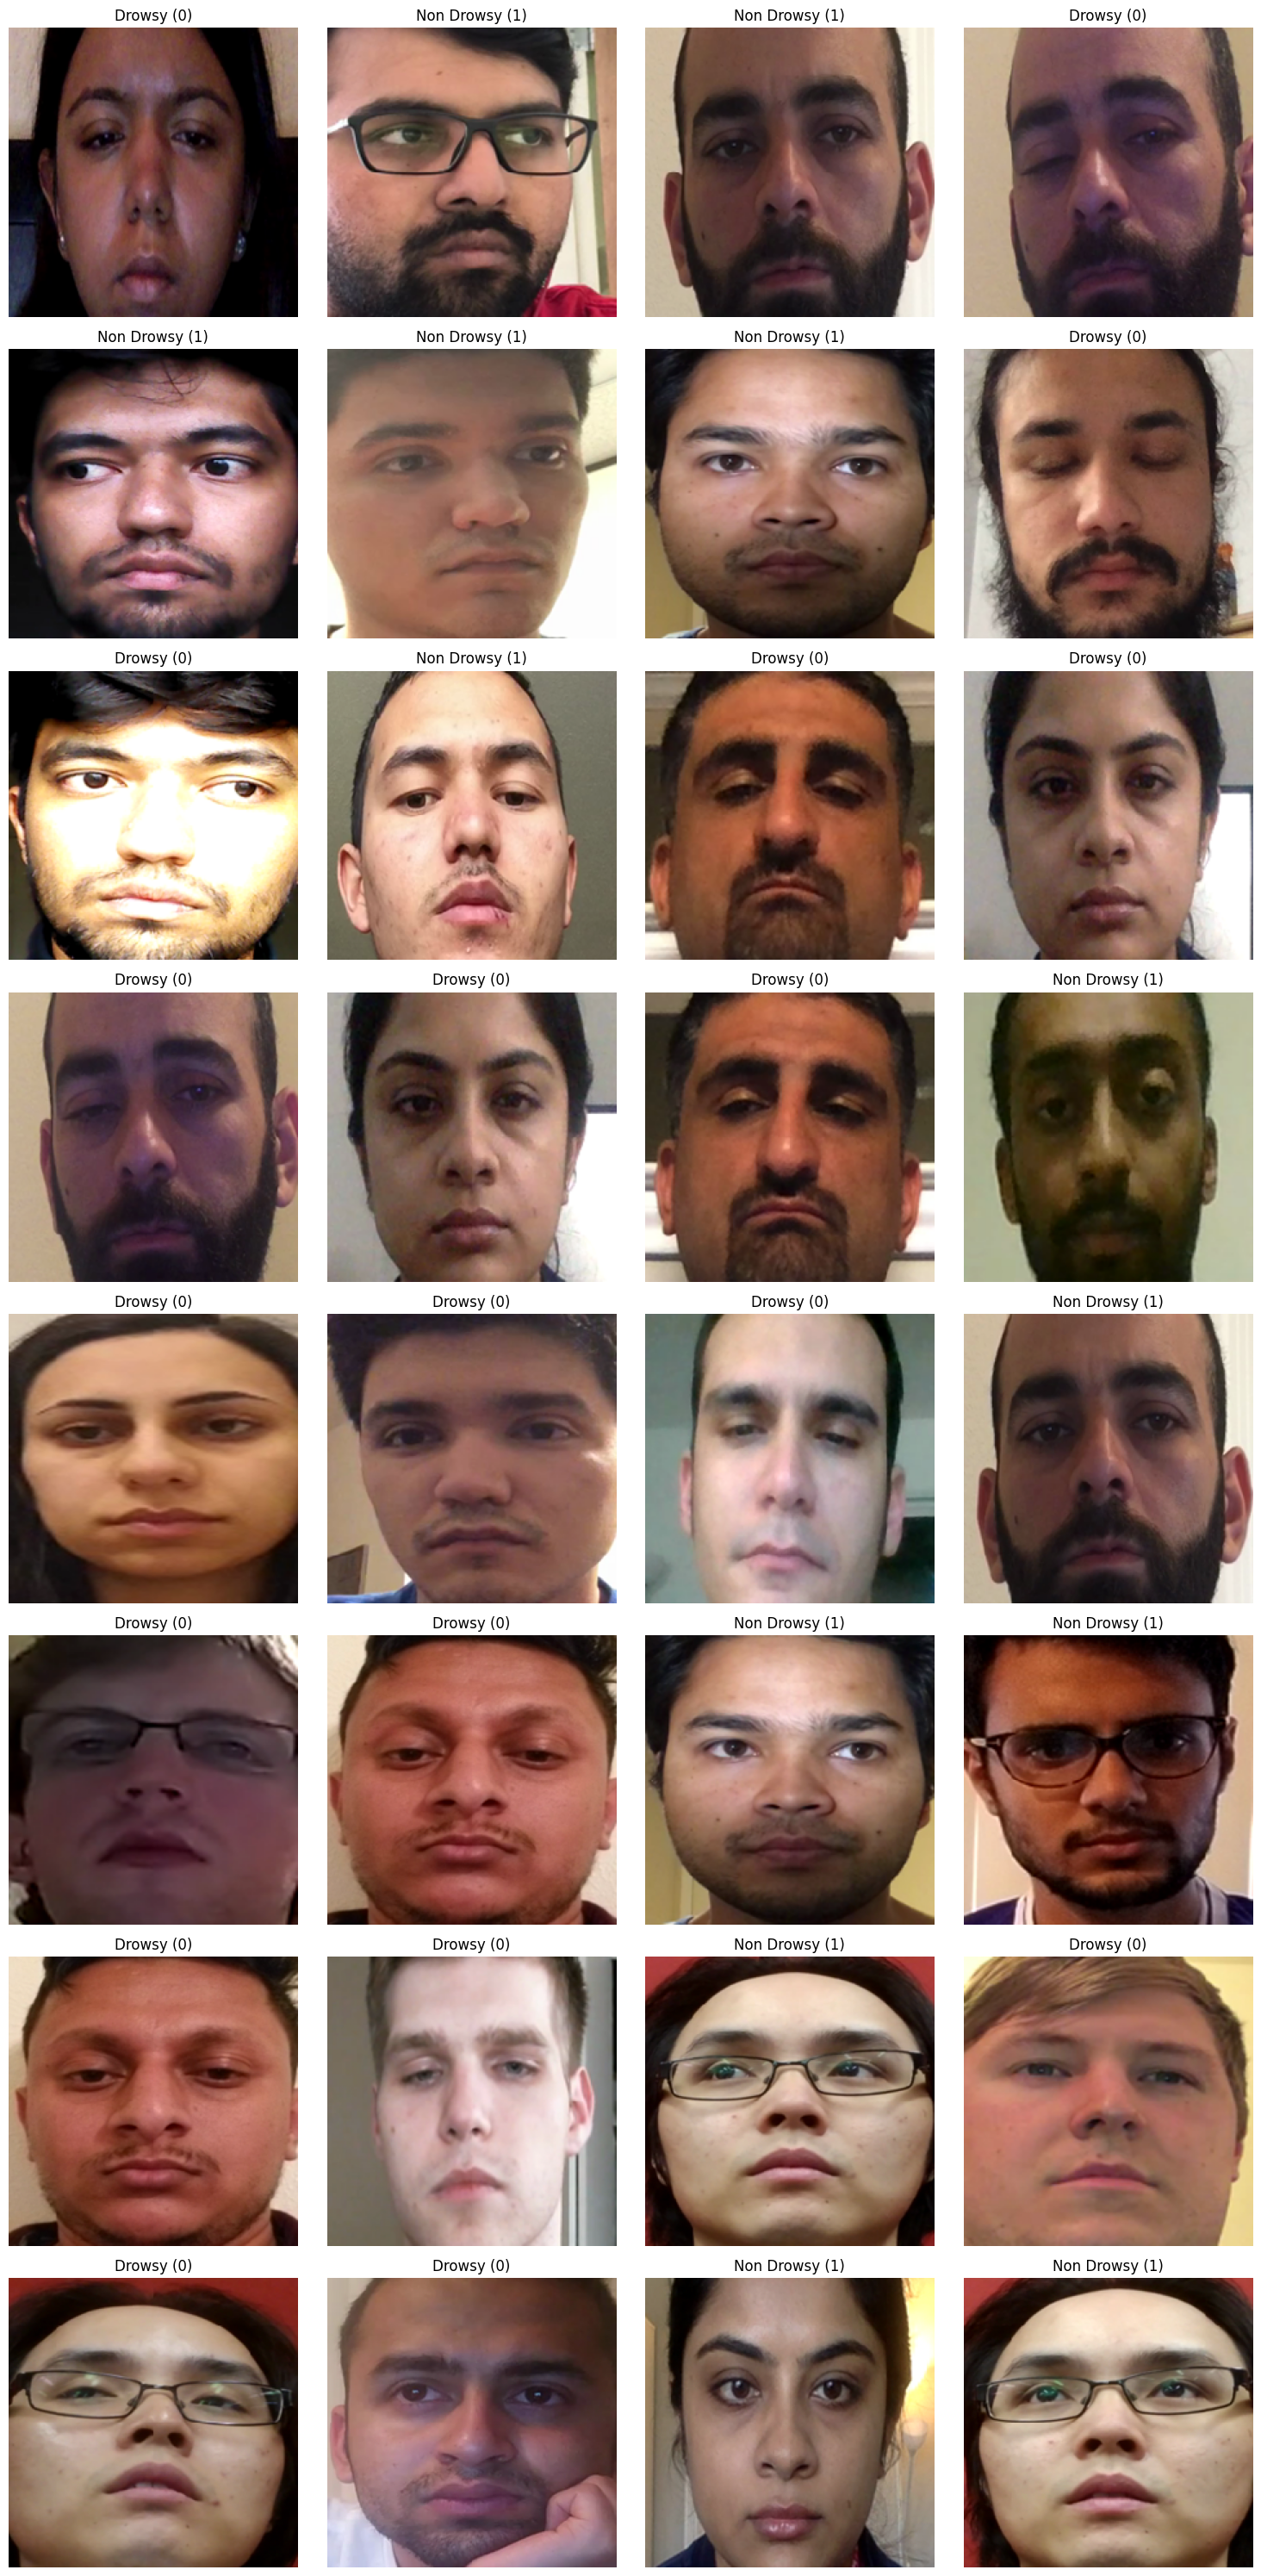

In [13]:
fig, axes = plt.subplots(8, 4, figsize=(15, 30))
class_indices = train_batches.class_indices

for i in range(8):
    images, labels = next(train_batches)
    for j in range(4):

        ax = axes[i, j]
        ax.imshow(images[j])
        ax.axis('off')
        label = int(labels[j])
        label_name = list(class_indices.keys())[list(class_indices.values()).index(label)]
        ax.set_title(f'{label_name} ({label})')

plt.tight_layout()
plt.show()

In [14]:
from tensorflow.keras.applications import MobileNetV2
image_size = (224, 224)

base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(image_size[0], image_size[1], 3),
)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [15]:
base_model.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [16]:
model=keras.Sequential()

In [17]:
for layer in base_model.layers[:-25] :
    layer.trainable = False

In [18]:
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)

In [19]:
model = Model(inputs=base_model.input, outputs=predictions)

In [20]:
model.compile(optimizer=Adam(0.0001 ), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [21]:
history = model.fit(
   train_batches,
    epochs=10,
    validation_data=val_batches,
    batch_size=32
)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2090/2090 ━━━━━━━━━━━━━━━━━━━━ 211s 92ms/step - accuracy: 0.9797 - loss: 0.0955 - val_accuracy: 0.9995 - val_loss: 0.0029
Epoch 2/10
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 168s 80ms/step - accuracy: 0.9965 - loss: 0.0223 - val_accuracy: 1.0000 - val_loss: 7.8298e-05
Epoch 3/10
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 163s 78ms/step - accuracy: 0.9991 - loss: 0.0064 - val_accuracy: 0.9998 - val_loss: 0.0023
Epoch 4/10
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 158s 75ms/step - accuracy: 0.9990 - loss: 0.0056 - val_accuracy: 0.9997 - val_loss: 0.0042
Epoch 5/10
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 155s 74ms/step - accuracy: 0.9985 - loss: 0.0071 - val_accuracy: 0.9997 - val_loss: 0.0025
Epoch 6/10
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 154s 74ms/step - accuracy: 0.9996 - loss: 0.0016 - val_accuracy: 0.9998 - val_loss: 0.0036
Epoch 7/10
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 152s 73ms/step - accuracy: 0.9999 - loss: 0.0011 - val_accuracy: 0.9981 - val_loss: 0.0292
Epoch 8/10
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 151s 72ms/step - accuracy: 0.9995 

In [22]:
loss, accuracy = model.evaluate(train_batches)

print(f"Training Loss: {loss:.4f}")
print(f"Training Accuracy: {accuracy*100:.2f}%")

2090/2090 ━━━━━━━━━━━━━━━━━━━━ 128s 61ms/step - accuracy: 1.0000 - loss: 6.1134e-04
Training Loss: 0.0008
Training Accuracy: 99.99%


In [23]:
loss, accuracy = model.evaluate(test_batches)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy*100:.2f}%")

131/131 ━━━━━━━━━━━━━━━━━━━━ 12s 90ms/step - accuracy: 0.9993 - loss: 0.0049
Test Loss: 0.0074
Test Accuracy: 99.90%


In [24]:
y_pred = model.predict(test_batches)

y_pred_labels = np.argmax(y_pred, axis=1)

131/131 ━━━━━━━━━━━━━━━━━━━━ 14s 83ms/step


In [25]:
y_actual = test_batches.labels

In [26]:
conf_matrix = confusion_matrix(y_actual, y_pred_labels)

print(conf_matrix)

[[1117    1]
 [   1  972]]


In [27]:
model.save('drowsiness_model.h5')


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-27-c5034d463ccf>", line 1, in <cell line: 0>
    model.save('drowsiness_model.h5')
  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras/src/models/model.py", line 311, in save
    return saving_api.save_model(
           ^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_api.py", line 111, in save_model
    return legacy_h5_format.save_model_to_hdf5(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras/src/legacy/saving/legacy_h5_format.py", line 68, in save_model_to_hdf5
    save_optimizer_weights_to_hdf5_gr

TypeError: object of type 'NoneType' has no len()

In [ ]:
from google.colab import files
files.download('drowsiness_model.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

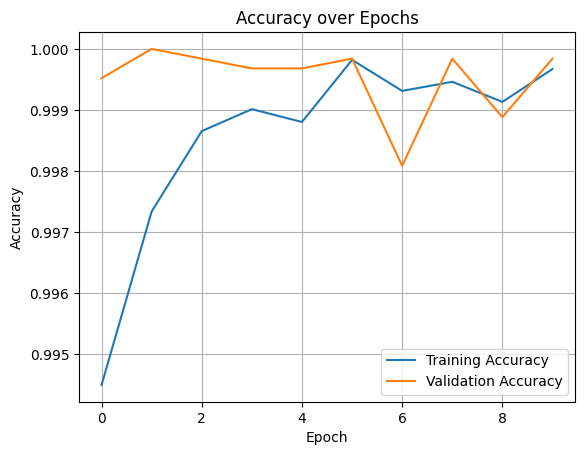

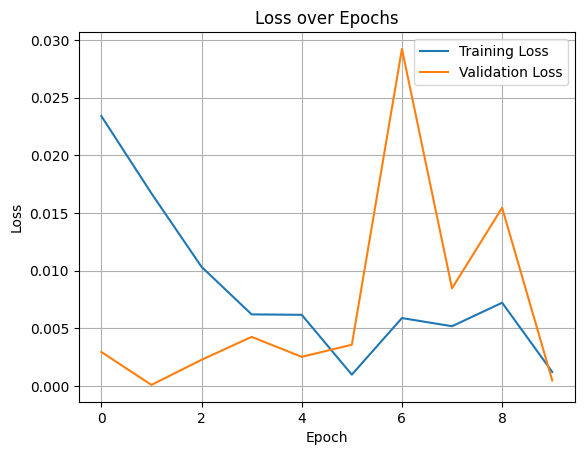

In [28]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from tensorflow.keras.preprocessing import image

# Path to one image from your test or validation set
img_path = 'kesh1.jpg'

# Load and preprocess the image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = img_array / 255.0  # Normalize
img_input = np.expand_dims(img_array, axis=0)

# Predict
prediction = model.predict(img_input)[0]
pred_label = np.argmax(prediction)
confidence = prediction[pred_label]

# Output label
label_text = "Drowsy" if pred_label == 1 else "Not Drowsy"

# Show image and prediction
plt.imshow(img)
plt.axis('off')
plt.title(f'Prediction: {label_text} ({confidence:.2f})')
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'kesh1.jpg'